**PROJECT 1**

03/03/2025

Carolina Torrente Vélez 100452137

Maria De Neira Ortiz 100472891


In this lab, your goal is to implement a deep autoencoder based on dense neural networks over MNIST and FMNIST databases:



1.   Validate a couple of networks (3 layers at both encoder/decoder vs 5 layers) and study the influence of the projected dimension (15,30,50,100)

2.   Implement regularization techniques. Also, regularizing the encoder's output with a Lasso can be a good idea.

3.   For the best architecture found, implement a denoising autoencoder. Use additive zero-mean Gaussian noise of a given (tunable) variance as injected noise. Analyze the performance as a function of the variance.


4.   Use the Peak signal-to-noise ratio (PSNR) as a performance metric and, of course, visualization of the reconstructed/denoised signals versus the input to the encoder.


Upload a zip file with a 3-page report with your main results and code for your experiments. The code can be a Python script or a Jupyter Notebook.
You can work in groups of up to three. Each of you uploads the solution to Aula Global!
Deadline is March, 3rd, at 23:59






In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import pandas as pd

# MNIST

## PART 1

In [2]:
# define a transform to convert the images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST training dataset7
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# dataset: randomly select 20000 samples from the dataset
dataset = torch.utils.data.Subset(mnist_dataset, torch.randperm(len(mnist_dataset))[:20000])

# create a dictionary to hold one sample per digit
samples = {}

# iterate over the subset and store the first occurrence of each digit (0 to 9)
for img, label in dataset:
    if label not in samples:
        samples[label] = img
    if len(samples) == 10:
        break


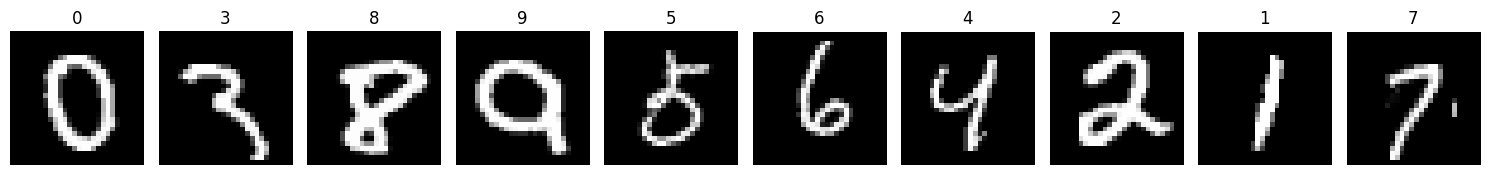

In [3]:
# plot one image per digit
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, (digit, img) in enumerate(samples.items()):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f'{digit}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [4]:
# extract the data and labels from the subset
data = []
labels = []
for img, label in dataset:
    data.append(img.view(-1).numpy())  # flatten the image
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

# split the dataset into training and temp sets (temp will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42)

# split the temporary set into 66% validation and 33% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

print("Training set shape:", X_train.shape, "with balanced class distribution:", np.bincount(y_train))
print("Validation set shape:", X_val.shape, "with balanced class distribution:", np.bincount(y_val))
print("Test set shape:", X_test.shape, "with balanced class distribution:", np.bincount(y_test))

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set shape: (14000, 784) with balanced class distribution: [1370 1575 1411 1415 1371 1247 1394 1436 1402 1379]
Validation set shape: (4000, 784) with balanced class distribution: [391 450 403 404 392 357 398 410 401 394]
Test set shape: (2000, 784) with balanced class distribution: [196 225 202 202 196 178 199 205 200 197]


### Model with 3 layers at both encoder/decoder

In [5]:
class Autoencoder3L(nn.Module):
    def __init__(self, dimension):
        super(Autoencoder3L, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dimension),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(dimension, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Model with 5 layers at both encoder/decoder

In [6]:
class Autoencoder5L(nn.Module):
   def __init__(self, dimension):
        super(Autoencoder5L, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, dimension),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(dimension, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid())

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

###Training function

In [7]:
def train(model, train_loader, val_loader, epochs=20, lr=0.001, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs, _ = batch
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, _ = batch
                inputs = inputs.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

### 3 layers 50 epochs


Training with latent dimension: 15
Epoch 1/50 - Train Loss: 0.0586, Val Loss: 0.0384
Epoch 2/50 - Train Loss: 0.0322, Val Loss: 0.0291
Epoch 3/50 - Train Loss: 0.0274, Val Loss: 0.0260
Epoch 4/50 - Train Loss: 0.0252, Val Loss: 0.0248
Epoch 5/50 - Train Loss: 0.0238, Val Loss: 0.0235
Epoch 6/50 - Train Loss: 0.0228, Val Loss: 0.0227
Epoch 7/50 - Train Loss: 0.0220, Val Loss: 0.0220
Epoch 8/50 - Train Loss: 0.0214, Val Loss: 0.0217
Epoch 9/50 - Train Loss: 0.0209, Val Loss: 0.0215
Epoch 10/50 - Train Loss: 0.0204, Val Loss: 0.0210
Epoch 11/50 - Train Loss: 0.0200, Val Loss: 0.0206
Epoch 12/50 - Train Loss: 0.0196, Val Loss: 0.0204
Epoch 13/50 - Train Loss: 0.0193, Val Loss: 0.0202
Epoch 14/50 - Train Loss: 0.0190, Val Loss: 0.0199
Epoch 15/50 - Train Loss: 0.0187, Val Loss: 0.0200
Epoch 16/50 - Train Loss: 0.0185, Val Loss: 0.0196
Epoch 17/50 - Train Loss: 0.0183, Val Loss: 0.0194
Epoch 18/50 - Train Loss: 0.0181, Val Loss: 0.0193
Epoch 19/50 - Train Loss: 0.0179, Val Loss: 0.0193
Epoc

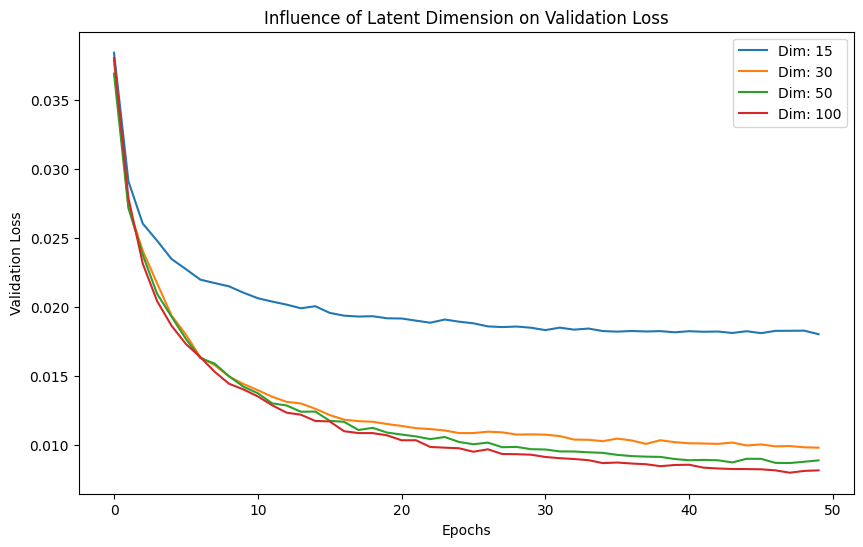

In [11]:
latent_dimensions = [15, 30, 50, 100]
results = {}
best_losses = []

for dim in latent_dimensions:
    print(f"\nTraining with latent dimension: {dim}")
    model = Autoencoder3L(dim)
    train_losses, val_losses = train(model, train_loader, val_loader, epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu')
    results[dim] = val_losses

    min_val_loss = min(val_losses)
    best_losses.append({'Latent Dimension': dim, 'Best Validation Loss': min_val_loss})
    print(f"Lowest validation loss for latent dimension {dim}: {min_val_loss:.4f}")

# Convert to DataFrame and save as Excel file
df = pd.DataFrame(best_losses)
df.to_excel("best_validation_losses.xlsx", index=False)

# Visualization
plt.figure(figsize=(10, 6))
for dim, losses in results.items():
    plt.plot(losses, label=f'Dim: {dim}')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Influence of Latent Dimension on Validation Loss')
plt.legend()
plt.show()

**3 Layer Architecture**

The best latent dimension is 100. This suggests that large latent dimension allows the model to capture more complex patterns and variability in the data, potentially improving its ability to generalize. However, this doesn't necessarily mean that the model with the smallest loss is the best; we need to consider the risk of overfitting.

Lowest validation loss for latent dimension 100: 0.0081

### 5 Layers and 50 epoch


Training with latent dimension: 15
Epoch 1/50 - Train Loss: 0.0664, Val Loss: 0.0527
Epoch 2/50 - Train Loss: 0.0490, Val Loss: 0.0458
Epoch 3/50 - Train Loss: 0.0427, Val Loss: 0.0395
Epoch 4/50 - Train Loss: 0.0377, Val Loss: 0.0363
Epoch 5/50 - Train Loss: 0.0346, Val Loss: 0.0338
Epoch 6/50 - Train Loss: 0.0323, Val Loss: 0.0310
Epoch 7/50 - Train Loss: 0.0293, Val Loss: 0.0280
Epoch 8/50 - Train Loss: 0.0271, Val Loss: 0.0263
Epoch 9/50 - Train Loss: 0.0254, Val Loss: 0.0251
Epoch 10/50 - Train Loss: 0.0243, Val Loss: 0.0244
Epoch 11/50 - Train Loss: 0.0233, Val Loss: 0.0233
Epoch 12/50 - Train Loss: 0.0226, Val Loss: 0.0229
Epoch 13/50 - Train Loss: 0.0220, Val Loss: 0.0226
Epoch 14/50 - Train Loss: 0.0215, Val Loss: 0.0219
Epoch 15/50 - Train Loss: 0.0211, Val Loss: 0.0217
Epoch 16/50 - Train Loss: 0.0206, Val Loss: 0.0215
Epoch 17/50 - Train Loss: 0.0203, Val Loss: 0.0216
Epoch 18/50 - Train Loss: 0.0200, Val Loss: 0.0209
Epoch 19/50 - Train Loss: 0.0197, Val Loss: 0.0210
Epoc

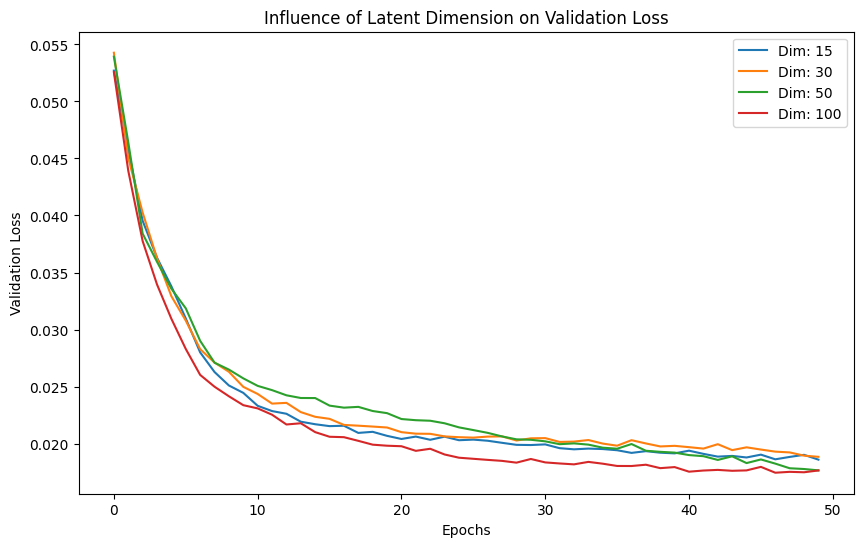

In [12]:
latent_dimensions = [15, 30, 50, 100]
results = {}
best_losses = []

for dim in latent_dimensions:
    print(f"\nTraining with latent dimension: {dim}")
    model = Autoencoder5L(dim)
    train_losses, val_losses = train(model, train_loader, val_loader, epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu')
    results[dim] = val_losses

    min_val_loss = min(val_losses)
    best_losses.append({'Latent Dimension': dim, 'Best Validation Loss': min_val_loss})
    print(f"Lowest validation loss for latent dimension {dim}: {min_val_loss:.4f}")

# Convert to DataFrame and save as Excel file
df = pd.DataFrame(best_losses)
df.to_excel("best_validation_losses_5L.xlsx", index=False)

# Visualization
plt.figure(figsize=(10, 6))
for dim, losses in results.items():
    plt.plot(losses, label=f'Dim: {dim}')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Influence of Latent Dimension on Validation Loss')
plt.legend()
plt.show()


**5 Layer Architecture**

The best latent dimension is 30 because in the provided training results, the lowest validation loss for the latent dimension of 30 is 0.0187. This is the best performance among the tested dimensions (15, ,30 50, 100). For a balanced trade-off between compression and model performance, dimension 30 is optimal because it achieves a relatively low loss while maintaining a sufficiently compact representation. Lower latent dimensions (e.g., 15) may not capture enough information, and higher dimensions (e.g., 50 or 100) don't significantly improve the validation loss and could lead to overfitting or unnecessary complexity.

## PART 2


In [ ]:
# Define the functions for regularization
def apply_l1_regularization(model, lasso_lambda):
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.norm(param, p=1)
    return lasso_lambda * l1_loss

def apply_l2_regularization(optimizer, ridge_lambda):
    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = ridge_lambda

def apply_dropout(rate):
    return nn.Dropout(rate)

def apply_batch_norm(size):
    return nn.BatchNorm1d(size)

def apply_layer_norm(size):
    return nn.LayerNorm(size)

# redefine autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim, dropout_rate, use_batch_norm, use_layer_norm):
        super(Autoencoder, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            apply_batch_norm(256) if use_batch_norm else nn.Identity(),
            apply_layer_norm(256) if use_layer_norm else nn.Identity(),
            nn.ReLU(),
            apply_dropout(dropout_rate),

            nn.Linear(256, 128),
            apply_batch_norm(128) if use_batch_norm else nn.Identity(),
            apply_layer_norm(128) if use_layer_norm else nn.Identity(),
            nn.ReLU(),
            apply_dropout(dropout_rate),

            nn.Linear(128, encoding_dim),
            nn.ReLU())

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Training loop with early stopping and tracking losses
def train_autoencoder_search(encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, lasso_lambda, ridge_lambda, batch_size, num_epochs, noise_variance=0.1, patience=5):
    model = Autoencoder(encoding_dim, dropout_rate, use_batch_norm, use_layer_norm).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    apply_l2_regularization(optimizer, ridge_lambda)

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for img, _ in train_loader:  # Using train_loader from your dataset
            img = img.to(device)

            # Add noise
            img_noisy = img + noise_variance * torch.randn(img.size()).to(device)
            img_noisy = torch.clamp(img_noisy, 0., 1.)

            # Forward pass
            output = model(img_noisy)
            loss = criterion(output, img) + apply_l1_regularization(model, lasso_lambda)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        # Validation Step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, _ in val_loader:  # Use validation data
                img = img.to(device)
                img_noisy = img + noise_variance * torch.randn(img.size()).to(device)
                img_noisy = torch.clamp(img_noisy, 0., 1.)
                output = model(img_noisy)
                val_loss += criterion(output, img).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping criteria
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the best model's state
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Restore the best model state
    model.load_state_dict(best_model_state)

    return train_losses, val_losses, best_val_loss

In [ ]:
# Step 1: Initial hyperparameter search
def initial_hyperparameter_search():
    encoding_dims = [15, 30, 50, 100]
    lasso_lambdas = [0.0001, 0.001, 0.01, 0.1]
    ridge_lambdas = [0.0001, 0.001, 0.01, 0.1]
    batch_sizes = [32, 64, 128]
    num_epochs_list = 20  # Adjust this based on time or computational constraints
    patience = 5  # Early stopping patience

    results_initial = []

    for encoding_dim in encoding_dims:
        for lasso_lambda in lasso_lambdas:
            for ridge_lambda in ridge_lambdas:
                for batch_size in batch_sizes:
                    print(f"Training with encoding_dim={encoding_dim}, lasso_lambda={lasso_lambda}, ridge_lambda={ridge_lambda}, batch_size={batch_size}")

                    train_losses, val_losses, val_loss = train_autoencoder_search(
                        encoding_dim, dropout_rate=0.0, use_batch_norm=False, use_layer_norm=False,
                        lasso_lambda=lasso_lambda, ridge_lambda=ridge_lambda, batch_size=batch_size,
                        num_epochs=num_epochs_list, patience=patience)

                    # Store results from the initial search
                    results_initial.append({
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'params': {
                            'encoding_dim': encoding_dim,
                            'lasso_lambda': lasso_lambda,
                            'ridge_lambda': ridge_lambda,
                            'batch_size': batch_size
                        },
                        'val_loss': val_loss
                    })

    # Return the results for further analysis
    return results_initial



In [ ]:
# Step 2: Regularization search based on the best combination from the initial search
def regularization_search(best_params):
    dropout_rates = [0.0, 0.2, 0.5]
    batch_norm = [True, False]
    layer_norm = [True, False]
    results_regularization = []
    num_epochs_list=20

    encoding_dim = best_params['encoding_dim']
    lasso_lambda = best_params['lasso_lambda']
    ridge_lambda = best_params['ridge_lambda']
    batch_size = best_params['batch_size']

    for dropout_rate in dropout_rates:
        for use_batch_norm in batch_norm:
            for use_layer_norm in layer_norm:
                print(f"Training with regularization dropout_rate={dropout_rate}, batch_norm={use_batch_norm}, layer_norm={use_layer_norm}")

                # Perform training with the selected regularization techniques
                train_losses, val_losses, val_loss = train_autoencoder_search(
                    encoding_dim, dropout_rate, use_batch_norm, use_layer_norm,
                    lasso_lambda, ridge_lambda, batch_size, num_epochs=num_epochs_list, patience=5)

                # Store the results from the regularization search
                results_regularization.append({
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'params': {
                        'encoding_dim': encoding_dim,
                        'lasso_lambda': lasso_lambda,
                        'ridge_lambda': ridge_lambda,
                        'dropout_rate': dropout_rate,
                        'use_batch_norm': use_batch_norm,
                        'use_layer_norm': use_layer_norm,
                        'batch_size': batch_size
                    },
                    'val_loss': val_loss
                })

    # Return the results for further analysis
    return results_regularization



In [ ]:
# Step 3: Combine initial search and regularization search, and plot results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for result in results:
        label = f"EncDim={result['params']['encoding_dim']}, Lasso={result['params']['lasso_lambda']}, Ridge={result['params']['ridge_lambda']}, Dropout={result['params']['dropout_rate']}, BatchNorm={result['params']['use_batch_norm']}, LayerNorm={result['params']['use_layer_norm']}, BatchSize={result['params']['batch_size']}"
        plt.plot(result['train_losses'], label=f"Train - {label}")
        plt.plot(result['val_losses'], label=f"Val - {label}")

    plt.title("Training and Validation Loss Over Epochs for Different Hyperparameter Combinations")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right", fontsize=6)
    plt.grid(True)
    plt.show()

# Run the initial search to get the best parameters
results_initial = initial_hyperparameter_search()

# Select the best configuration based on the validation loss from the initial search
best_result = min(results_initial, key=lambda x: x['val_loss'])
best_params = best_result['params']
print(f"Best hyperparameters found: {best_params}")

# Now perform the regularization search with the best parameters found previously
results_regularization = regularization_search(best_params)

# Plot the results of the regularization search
plot_results(results_regularization)

Training with encoding_dim=15, lasso_lambda=0.0001, ridge_lambda=0.0001, batch_size=32
Epoch [1/20], Train Loss: 0.2841, Validation Loss: 0.1787
Epoch [2/20], Train Loss: 0.1959, Validation Loss: 0.1520
Epoch [3/20], Train Loss: 0.1867, Validation Loss: 0.1414
Epoch [4/20], Train Loss: 0.1837, Validation Loss: 0.1381
Epoch [5/20], Train Loss: 0.1829, Validation Loss: 0.1374
Epoch [6/20], Train Loss: 0.1827, Validation Loss: 0.1372
Epoch [7/20], Train Loss: 0.1827, Validation Loss: 0.1370
Epoch [8/20], Train Loss: 0.1827, Validation Loss: 0.1370
Epoch [9/20], Train Loss: 0.1827, Validation Loss: 0.1372
Epoch [10/20], Train Loss: 0.1828, Validation Loss: 0.1371
Epoch [11/20], Train Loss: 0.1828, Validation Loss: 0.1371
Epoch [12/20], Train Loss: 0.1829, Validation Loss: 0.1371
Early stopping triggered after 12 epochs.
Training with encoding_dim=15, lasso_lambda=0.0001, ridge_lambda=0.0001, batch_size=64
Epoch [1/20], Train Loss: 0.2838, Validation Loss: 0.1786
Epoch [2/20], Train Loss: 0

Best hyperparameters found: {'encoding_dim': 50, 'lasso_lambda': 0.0001, 'ridge_lambda': 0.0001, 'batch_size': 32}
Training with regularization dropout_rate=0.0, batch_norm=True, layer_norm=True

In [ ]:
best_result2 = min(results_regularization, key=lambda x: x['val_loss'])
best_params = best_result2['params']
best_val_loss = best_result2['val_loss']

print(f"Best hyperparameters found for the second grid search: {best_params}")
print(f"Best validation loss: {best_val_loss:.4f}")


Best hyperparameters found for the second grid search: {'encoding_dim': 50, 'lasso_lambda': 0.0001, 'ridge_lambda': 0.0001, 'dropout_rate': 0.0, 'use_batch_norm': False, 'use_layer_norm': True, 'batch_size': 32}
Best validation loss: 0.0641


## PART 3

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, encoding_dim, dropout_rate, use_batch_norm, use_layer_norm):
        super(DenoisingAutoencoder, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            apply_batch_norm(256) if use_batch_norm else nn.Identity(),
            apply_layer_norm(256) if use_layer_norm else nn.Identity(),
            nn.ReLU(),
            apply_dropout(dropout_rate),

            nn.Linear(256, 128),
            apply_batch_norm(128) if use_batch_norm else nn.Identity(),
            apply_layer_norm(128) if use_layer_norm else nn.Identity(),
            nn.ReLU(),
            apply_dropout(dropout_rate),

            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Function to train the Denoising Autoencoder with noise
def train_denoising_autoencoder(encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, batch_size, num_epochs, noise_variance, patience=5):
    model = DenoisingAutoencoder(encoding_dim, dropout_rate, use_batch_norm, use_layer_norm).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    early_stopping_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for img, _ in train_loader:  # Using train_loader from your dataset
            img = img.to(device)

            # Add noise to the input images
            img_noisy = img + noise_variance * torch.randn(img.size()).to(device)
            img_noisy = torch.clamp(img_noisy, 0., 1.)  # Clamp values to [0, 1]

            # Forward pass
            output = model(img_noisy)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        avg_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_epoch_train_loss)

        # Validation Step
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for img, _ in val_loader:  # Use validation data
                img = img.to(device)
                img_noisy = img + noise_variance * torch.randn(img.size()).to(device)
                img_noisy = torch.clamp(img_noisy, 0., 1.)
                output = model(img_noisy)
                epoch_val_loss += criterion(output, img).item()

        avg_epoch_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_epoch_val_loss)

        # Early Stopping Check
        if avg_epoch_val_loss < best_val_loss:
            best_val_loss = avg_epoch_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4f}, Validation Loss: {avg_epoch_val_loss:.4f}")

    return train_losses, val_losses, best_val_loss


# Analyze the performance as a function of noise variance
def analyze_noise_variance(noise_variances, encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, batch_size, num_epochs):
    results = {}

    for noise_variance in noise_variances:
        print(f"Training with noise variance: {noise_variance}")
        train_losses, val_losses, best_val_loss = train_denoising_autoencoder(
            encoding_dim, dropout_rate, use_batch_norm, use_layer_norm,
            batch_size, num_epochs, noise_variance)

        results[noise_variance] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss
        }

    return results


# Plot the results of noise variance analysis
def plot_noise_variance_results(results):
    plt.figure(figsize=(10, 6))

    for noise_variance, result in results.items():
        plt.plot(result['val_losses'], label=f"Noise Variance={noise_variance:.4f}")

    plt.title("Validation Loss Over Epochs for Different Noise Variances")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend(loc="upper right", fontsize=8)
    plt.grid(True)
    plt.show()



Training with noise variance: 0.01
Epoch [1/20], Train Loss: 0.0684, Validation Loss: 0.0510
Epoch [2/20], Train Loss: 0.0403, Validation Loss: 0.0324
Epoch [3/20], Train Loss: 0.0288, Validation Loss: 0.0257
Epoch [4/20], Train Loss: 0.0236, Validation Loss: 0.0223
Epoch [5/20], Train Loss: 0.0206, Validation Loss: 0.0197
Epoch [6/20], Train Loss: 0.0187, Validation Loss: 0.0184
Epoch [7/20], Train Loss: 0.0172, Validation Loss: 0.0170
Epoch [8/20], Train Loss: 0.0160, Validation Loss: 0.0163
Epoch [9/20], Train Loss: 0.0151, Validation Loss: 0.0156
Epoch [10/20], Train Loss: 0.0142, Validation Loss: 0.0145
Epoch [11/20], Train Loss: 0.0134, Validation Loss: 0.0138
Epoch [12/20], Train Loss: 0.0128, Validation Loss: 0.0133
Epoch [13/20], Train Loss: 0.0122, Validation Loss: 0.0129
Epoch [14/20], Train Loss: 0.0118, Validation Loss: 0.0126
Epoch [15/20], Train Loss: 0.0114, Validation Loss: 0.0121
Epoch [16/20], Train Loss: 0.0111, Validation Loss: 0.0118
Epoch [17/20], Train Loss: 0.0

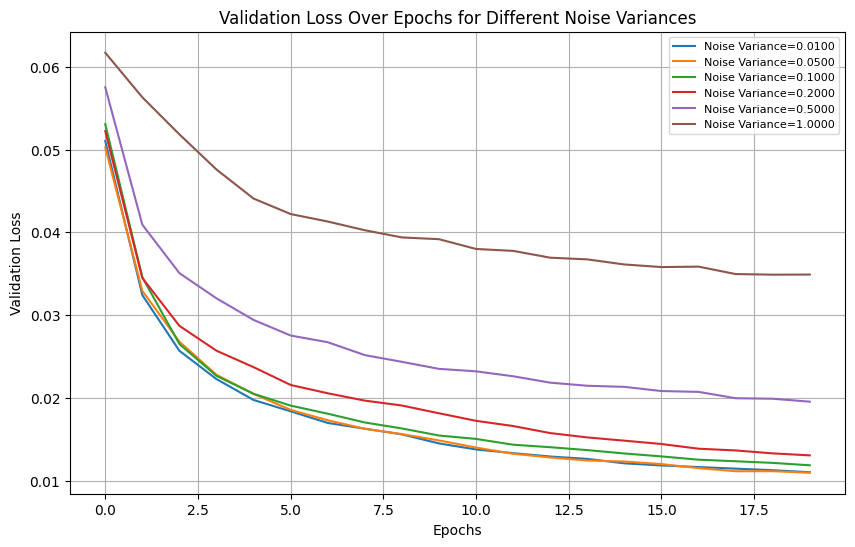

In [ ]:
# Experiment with different noise variances
noise_variances = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
encoding_dim = 50  # Best encoding dimension from previous search
dropout_rate = 0.0  # Based on best results
use_batch_norm = False
use_layer_norm = True
batch_size = 32
num_epochs = 20  # Adjust based on the available time

# Analyze and plot the results
results = analyze_noise_variance(noise_variances, encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, batch_size, num_epochs)
plot_noise_variance_results(results)

The minimum validation loss found for each noise variance (autoencoder dim =50!! which was a previous result):

Noise variance = 0.01: Min validation loss = 0.0110
Noise variance = 0.05: Min validation loss = 0.0110
Noise variance = 0.1: Min validation loss = 0.0119
Noise variance = 0.2: Min validation loss = 0.0131
Noise variance = 0.5: Min validation loss = 0.0195
Noise variance = 1.0: Min validation loss = 0.0349

So, the min validation loss is 0.0110, which is achieved with noise variance = 0.01 and noise variance = 0.05.

LATENT DIM = 15

Noise Variance: 0.01 → Best Validation Loss: 0.0167 (Epoch 19)

Noise Variance: 0.05 → Best Validation Loss: 0.0149 (Epoch 19)

Noise Variance: 0.1 → Best Validation Loss: 0.0145 (Epoch 20)

Noise Variance: 0.2 → Best Validation Loss: 0.0153 (Epoch 20)

Noise Variance: 0.5 → Best Validation Loss: 0.0214 (Epoch 20)

Noise Variance: 1.0 → Best Validation Loss: 0.0348 (Epoch 20)

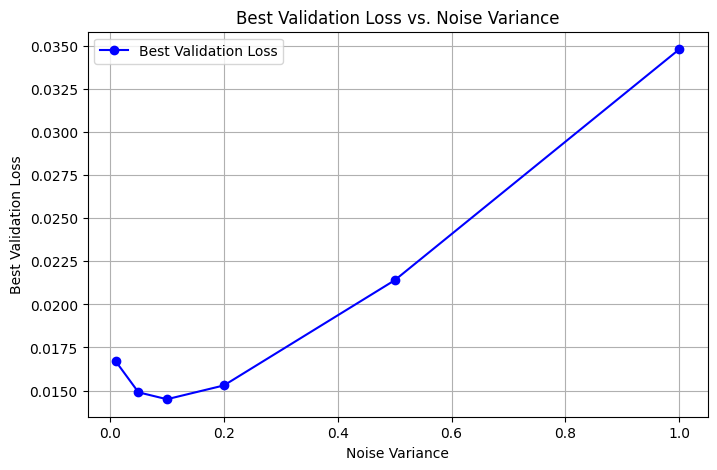

In [ ]:
noise_variances = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
best_validation_losses = [0.0167, 0.0149, 0.0145, 0.0153, 0.0214, 0.0348]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(noise_variances, best_validation_losses, marker='o', linestyle='-', color='b', label='Best Validation Loss')

# Labels and Title
plt.xlabel('Noise Variance')
plt.ylabel('Best Validation Loss')
plt.title('Best Validation Loss vs. Noise Variance')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


## PART 4

### PSNR Peak signal-to-noise ratio

In [ ]:
# Function to calculate PSNR
def calculate_psnr(original, reconstructed, max_val=1.0):
    mse = torch.mean((original - reconstructed) ** 2)
    if mse == 0:
        return 100  # Infinite PSNR when there is no error
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr.item()

# Visualization of a few noisy and reconstructed images
def visualize_reconstructed_images(noisy_images, reconstructed_images, original_images, n=5):
    noisy_images = noisy_images[:n].cpu().numpy().reshape(-1, 28, 28)
    reconstructed_images = reconstructed_images[:n].cpu().detach().numpy().reshape(-1, 28, 28)
    original_images = original_images[:n].cpu().numpy().reshape(-1, 28, 28)

    fig, axes = plt.subplots(n, 3, figsize=(8, 2 * n))
    for i in range(n):
        axes[i, 0].imshow(noisy_images[i], cmap="gray")
        axes[i, 0].set_title("Noisy Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(original_images[i], cmap="gray")
        axes[i, 1].set_title("Original Image")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(reconstructed_images[i], cmap="gray")
        axes[i, 2].set_title("Reconstructed Image")
        axes[i, 2].axis("off")

    plt.show()


# Function to train the Denoising Autoencoder with noise and calculate PSNR
def train_denoising_autoencoder_with_psnr(encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, batch_size, num_epochs, noise_variance, patience=5):
    model = DenoisingAutoencoder(encoding_dim, dropout_rate, use_batch_norm, use_layer_norm).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    early_stopping_counter = 0
    train_losses = []
    val_losses = []
    psnrs = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_psnr = 0.0
        for img, _ in train_loader:  # Using train_loader from your dataset
            img = img.to(device)

            # Add noise to the input images
            img_noisy = img + noise_variance * torch.randn(img.size()).to(device)
            img_noisy = torch.clamp(img_noisy, 0., 1.)  # Clamp values to [0, 1]

            # Forward pass
            output = model(img_noisy)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            # Calculate PSNR
            psnr = calculate_psnr(img, output)
            epoch_psnr += psnr

        avg_epoch_train_loss = epoch_train_loss / len(train_loader)
        avg_epoch_psnr = epoch_psnr / len(train_loader)
        train_losses.append(avg_epoch_train_loss)
        psnrs.append(avg_epoch_psnr)

        # Validation Step
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_psnr = 0.0
        with torch.no_grad():
            for img, _ in val_loader:  # Use validation data
                img = img.to(device)
                img_noisy = img + noise_variance * torch.randn(img.size()).to(device)
                img_noisy = torch.clamp(img_noisy, 0., 1.)
                output = model(img_noisy)
                epoch_val_loss += criterion(output, img).item()

                # Calculate PSNR
                val_psnr = calculate_psnr(img, output)
                epoch_val_psnr += val_psnr

        avg_epoch_val_loss = epoch_val_loss / len(val_loader)
        avg_epoch_val_psnr = epoch_val_psnr / len(val_loader)
        val_losses.append(avg_epoch_val_loss)

        # Early Stopping Check
        if avg_epoch_val_loss < best_val_loss:
            best_val_loss = avg_epoch_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4f}, Validation Loss: {avg_epoch_val_loss:.4f}, PSNR: {avg_epoch_psnr:.2f}")

    return model, train_losses, val_losses, psnrs, best_val_loss



# Analyze performance with noise variance and visualize results
def analyze_noise_variance_and_visualize(noise_variances, encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, batch_size, num_epochs):
    results = {}

    for noise_variance in noise_variances:
        print(f"Training with noise variance: {noise_variance}")
        model, train_losses, val_losses, psnrs, best_val_loss = train_denoising_autoencoder_with_psnr(
            encoding_dim, dropout_rate, use_batch_norm, use_layer_norm,
            batch_size, num_epochs, noise_variance)

        results[noise_variance] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'psnrs': psnrs,
            'best_val_loss': best_val_loss
        }

        # After training, visualize some reconstructed images (you can adjust n)
        model.eval()
        with torch.no_grad():
            for img, _ in val_loader:  # Visualize a batch from validation set
                img = img.to(device)
                img_noisy = img + noise_variance * torch.randn(img.size()).to(device)
                img_noisy = torch.clamp(img_noisy, 0., 1.)
                output = model(img_noisy)
                visualize_reconstructed_images(img_noisy, output, img, n=5)
                break  # Visualize one batch and break

    return results



Training with noise variance: 0.1
Epoch [1/20], Train Loss: 0.0572, Validation Loss: 0.0377, PSNR: 12.66
Epoch [2/20], Train Loss: 0.0317, Validation Loss: 0.0281, PSNR: 15.02
Epoch [3/20], Train Loss: 0.0256, Validation Loss: 0.0238, PSNR: 15.94
Epoch [4/20], Train Loss: 0.0218, Validation Loss: 0.0209, PSNR: 16.64
Epoch [5/20], Train Loss: 0.0193, Validation Loss: 0.0191, PSNR: 17.16
Epoch [6/20], Train Loss: 0.0177, Validation Loss: 0.0176, PSNR: 17.55
Epoch [7/20], Train Loss: 0.0165, Validation Loss: 0.0166, PSNR: 17.86
Epoch [8/20], Train Loss: 0.0155, Validation Loss: 0.0158, PSNR: 18.11
Epoch [9/20], Train Loss: 0.0146, Validation Loss: 0.0150, PSNR: 18.38
Epoch [10/20], Train Loss: 0.0138, Validation Loss: 0.0143, PSNR: 18.61
Epoch [11/20], Train Loss: 0.0131, Validation Loss: 0.0136, PSNR: 18.85
Epoch [12/20], Train Loss: 0.0125, Validation Loss: 0.0132, PSNR: 19.04
Epoch [13/20], Train Loss: 0.0120, Validation Loss: 0.0127, PSNR: 19.22
Epoch [14/20], Train Loss: 0.0116, Vali

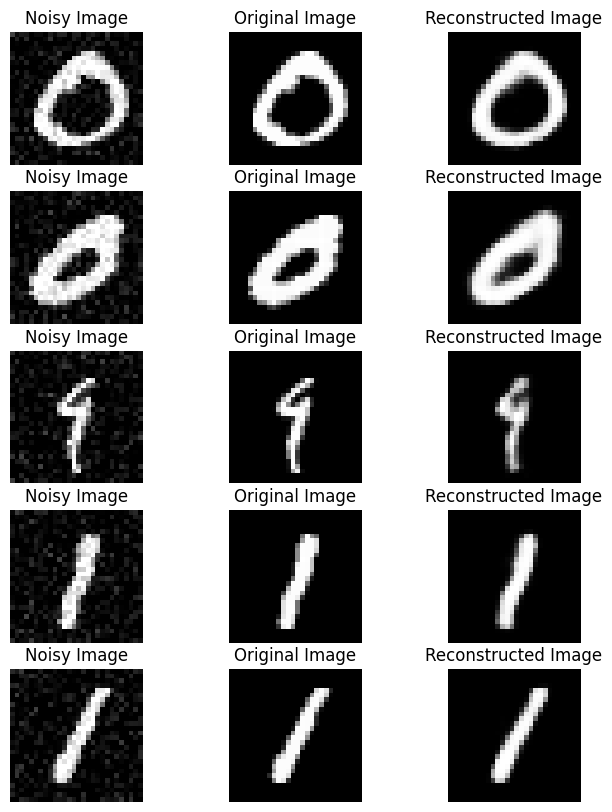

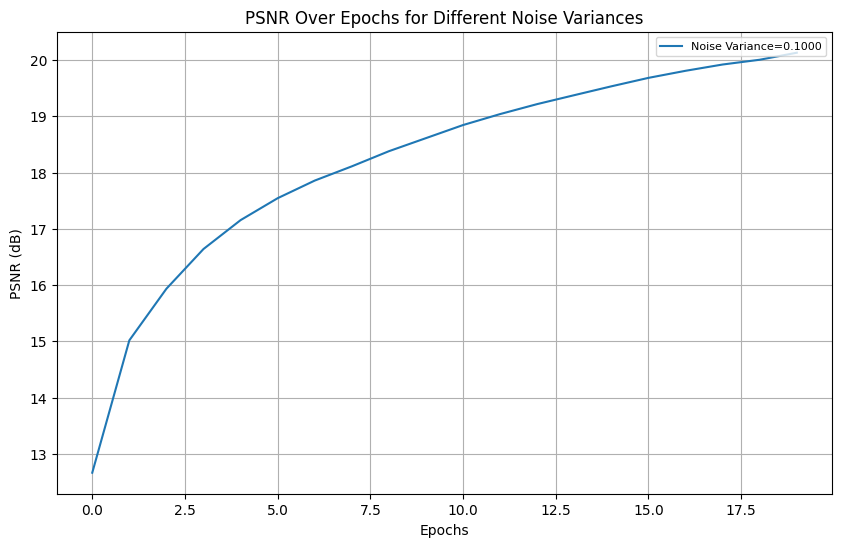

In [ ]:
# Experiment with different noise variances
noise_variances = [0.1]
encoding_dim = 50  # Best encoding dimension from previous search
dropout_rate = 0.0  # Based on best results
use_batch_norm = False
use_layer_norm = True
batch_size = 32
num_epochs = 20  # Adjust based on the available time

# Analyze and plot the results
results = analyze_noise_variance_and_visualize(noise_variances, encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, batch_size, num_epochs)

# Plot PSNR over epochs for different noise variances
plt.figure(figsize=(10, 6))

for noise_variance, result in results.items():
    plt.plot(result['psnrs'], label=f"Noise Variance={noise_variance:.4f}")

plt.title("PSNR Over Epochs for Different Noise Variances")
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True)
plt.show()

# FMNIST

## PART 1

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

fashion_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)



100%|██████████| 26.4M/26.4M [00:01<00:00, 18.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.61MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.7MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



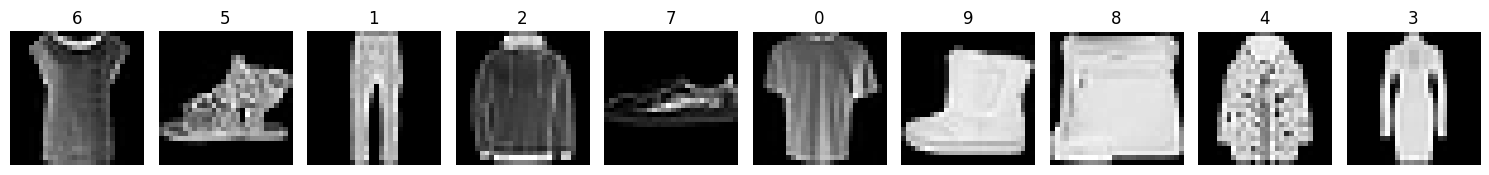

In [ ]:
# dataset: randomly select 20000 samples from the dataset
dataset = torch.utils.data.Subset(fashion_dataset, torch.randperm(len(fashion_dataset))[:20000])

# create a dictionary to hold one sample per digit
samples = {}

# iterate over the subset and store the first occurrence of each digit (0 to 9)
for img, label in dataset:
    if label not in samples:
        samples[label] = img
    if len(samples) == 10:
        break

# plot one image per digit
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, (digit, img) in enumerate(samples.items()):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f'{digit}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# first, extract the data and labels from the subset
data = []
labels = []
for img, label in dataset:
    data.append(img.view(-1).numpy())  # flatten the image
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

# split the dataset into training and temp sets (temp will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42)

# split the temporary set into 66% validation and 33% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

print("Training set shape:", X_train.shape, "with balanced class distribution:", np.bincount(y_train))
print("Validation set shape:", X_val.shape, "with balanced class distribution:", np.bincount(y_val))
print("Test set shape:", X_test.shape, "with balanced class distribution:", np.bincount(y_test))

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set shape: (14000, 784) with balanced class distribution: [1378 1437 1415 1400 1411 1352 1425 1369 1432 1381]
Validation set shape: (4000, 784) with balanced class distribution: [393 411 405 400 404 386 407 391 409 394]
Test set shape: (2000, 784) with balanced class distribution: [197 205 202 200 201 193 204 196 205 197]


### training and Autoencoders of 3 and 5 layers were already defined


Training with latent dimension: 15
Epoch 1/30 - Train Loss: 0.0591, Val Loss: 0.0330
Epoch 2/30 - Train Loss: 0.0295, Val Loss: 0.0264
Epoch 3/30 - Train Loss: 0.0252, Val Loss: 0.0248
Epoch 4/30 - Train Loss: 0.0234, Val Loss: 0.0226
Epoch 5/30 - Train Loss: 0.0222, Val Loss: 0.0220
Epoch 6/30 - Train Loss: 0.0213, Val Loss: 0.0209
Epoch 7/30 - Train Loss: 0.0206, Val Loss: 0.0203
Epoch 8/30 - Train Loss: 0.0200, Val Loss: 0.0197
Epoch 9/30 - Train Loss: 0.0193, Val Loss: 0.0193
Epoch 10/30 - Train Loss: 0.0189, Val Loss: 0.0189
Epoch 11/30 - Train Loss: 0.0185, Val Loss: 0.0187
Epoch 12/30 - Train Loss: 0.0182, Val Loss: 0.0184
Epoch 13/30 - Train Loss: 0.0180, Val Loss: 0.0183
Epoch 14/30 - Train Loss: 0.0178, Val Loss: 0.0180
Epoch 15/30 - Train Loss: 0.0176, Val Loss: 0.0180
Epoch 16/30 - Train Loss: 0.0174, Val Loss: 0.0177
Epoch 17/30 - Train Loss: 0.0172, Val Loss: 0.0176
Epoch 18/30 - Train Loss: 0.0171, Val Loss: 0.0177
Epoch 19/30 - Train Loss: 0.0170, Val Loss: 0.0173
Epoc

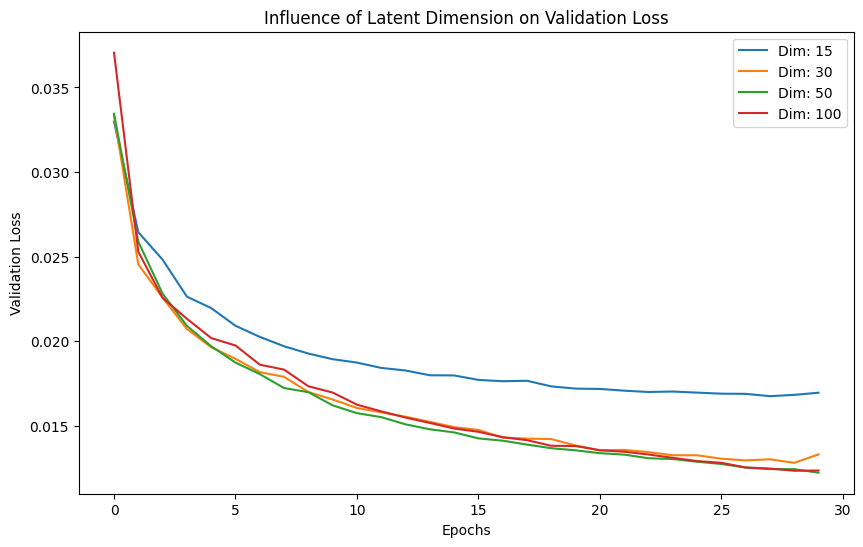

In [ ]:
# 3L and 30 epochs

latent_dimensions = [15, 30, 50, 100]
results = {}

for dim in latent_dimensions:
    print(f"\nTraining with latent dimension: {dim}")
    model = Autoencoder3L(dim)
    train_losses, val_losses = train(model, train_loader, val_loader, epochs=30, device='cuda' if torch.cuda.is_available() else 'cpu')
    results[dim] = val_losses

    min_val_loss = min(val_losses)
    print(f"Lowest validation loss for latent dimension {dim}: {min_val_loss:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
for dim, losses in results.items():
    plt.plot(losses, label=f'Dim: {dim}')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Influence of Latent Dimension on Validation Loss')
plt.legend()
plt.show()


Training with latent dimension: 15
Epoch 1/30 - Train Loss: 0.0673, Val Loss: 0.0407
Epoch 2/30 - Train Loss: 0.0376, Val Loss: 0.0355
Epoch 3/30 - Train Loss: 0.0333, Val Loss: 0.0309
Epoch 4/30 - Train Loss: 0.0299, Val Loss: 0.0294
Epoch 5/30 - Train Loss: 0.0280, Val Loss: 0.0271
Epoch 6/30 - Train Loss: 0.0267, Val Loss: 0.0268
Epoch 7/30 - Train Loss: 0.0250, Val Loss: 0.0243
Epoch 8/30 - Train Loss: 0.0239, Val Loss: 0.0236
Epoch 9/30 - Train Loss: 0.0232, Val Loss: 0.0229
Epoch 10/30 - Train Loss: 0.0226, Val Loss: 0.0224
Epoch 11/30 - Train Loss: 0.0223, Val Loss: 0.0224
Epoch 12/30 - Train Loss: 0.0217, Val Loss: 0.0217
Epoch 13/30 - Train Loss: 0.0216, Val Loss: 0.0216
Epoch 14/30 - Train Loss: 0.0212, Val Loss: 0.0212
Epoch 15/30 - Train Loss: 0.0210, Val Loss: 0.0211
Epoch 16/30 - Train Loss: 0.0208, Val Loss: 0.0209
Epoch 17/30 - Train Loss: 0.0205, Val Loss: 0.0206
Epoch 18/30 - Train Loss: 0.0204, Val Loss: 0.0206
Epoch 19/30 - Train Loss: 0.0202, Val Loss: 0.0205
Epoc

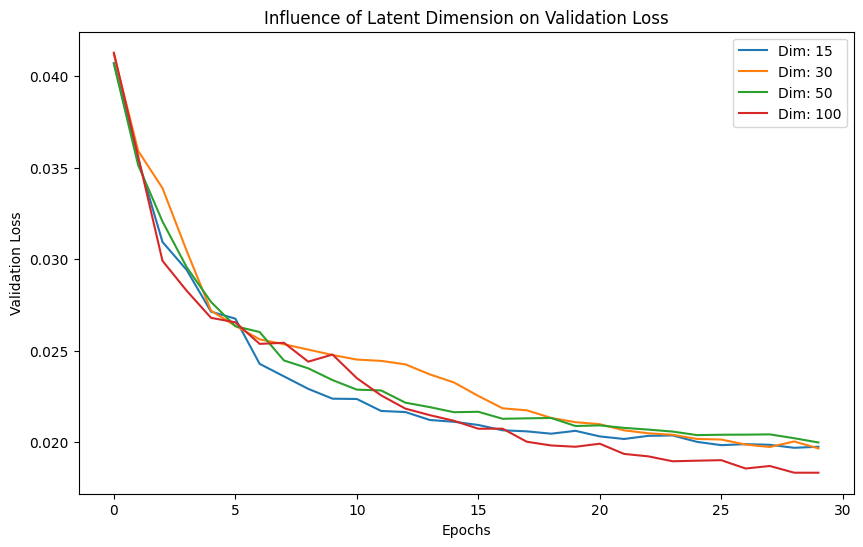

In [ ]:
latent_dimensions = [15, 30, 50, 100]
results = {}

for dim in latent_dimensions:
    print(f"\nTraining with latent dimension: {dim}")
    model = Autoencoder5L(dim)
    train_losses, val_losses = train(model, train_loader, val_loader, epochs=30, device='cuda' if torch.cuda.is_available() else 'cpu')
    results[dim] = val_losses

    min_val_loss = min(val_losses)
    print(f"Lowest validation loss for latent dimension {dim}: {min_val_loss:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
for dim, losses in results.items():
    plt.plot(losses, label=f'Dim: {dim}')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Influence of Latent Dimension on Validation Loss')
plt.legend()
plt.show()

## PART 2.

In [ ]:
def initial_hyperparameter_search():
    encoding_dims = [15, 30, 50, 100]
    lasso_lambdas = [0.0001, 0.001, 0.01]
    ridge_lambdas = [0.0001, 0.001, 0.01]
    batch_sizes = [32, 64, 128]
    num_epochs_list = 20  # Adjust this based on time or computational constraints
    patience = 5  # Early stopping patience

    results_initial = []

    for encoding_dim in encoding_dims:
        for lasso_lambda in lasso_lambdas:
            for ridge_lambda in ridge_lambdas:
                for batch_size in batch_sizes:
                    print(f"Training with encoding_dim={encoding_dim}, lasso_lambda={lasso_lambda}, ridge_lambda={ridge_lambda}, batch_size={batch_size}")

                    train_losses, val_losses, val_loss = train_autoencoder_search(
                        encoding_dim, dropout_rate=0.0, use_batch_norm=False, use_layer_norm=False,
                        lasso_lambda=lasso_lambda, ridge_lambda=ridge_lambda, batch_size=batch_size,
                        num_epochs=num_epochs_list, patience=patience)

                    # Store results from the initial search
                    results_initial.append({
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'params': {
                            'encoding_dim': encoding_dim,
                            'lasso_lambda': lasso_lambda,
                            'ridge_lambda': ridge_lambda,
                            'batch_size': batch_size
                        },
                        'val_loss': val_loss
                    })

    # Return the results for further analysis
    return results_initial

In [ ]:
# Step 2: Regularization search based on the best combination from the initial search
def regularization_search(best_params):
    dropout_rates = [0.0, 0.2, 0.5]
    batch_norm = [True, False]
    layer_norm = [True, False]
    results_regularization = []
    num_epochs_list=20

    encoding_dim = best_params['encoding_dim']
    lasso_lambda = best_params['lasso_lambda']
    ridge_lambda = best_params['ridge_lambda']
    batch_size = best_params['batch_size']

    for dropout_rate in dropout_rates:
        for use_batch_norm in batch_norm:
            for use_layer_norm in layer_norm:
                print(f"Training with regularization dropout_rate={dropout_rate}, batch_norm={use_batch_norm}, layer_norm={use_layer_norm}")

                # Perform training with the selected regularization techniques
                train_losses, val_losses, val_loss = train_autoencoder_search(
                    encoding_dim, dropout_rate, use_batch_norm, use_layer_norm,
                    lasso_lambda, ridge_lambda, batch_size, num_epochs=num_epochs_list, patience=5)

                # Store the results from the regularization search
                results_regularization.append({
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'params': {
                        'encoding_dim': encoding_dim,
                        'lasso_lambda': lasso_lambda,
                        'ridge_lambda': ridge_lambda,
                        'dropout_rate': dropout_rate,
                        'use_batch_norm': use_batch_norm,
                        'use_layer_norm': use_layer_norm,
                        'batch_size': batch_size
                    },
                    'val_loss': val_loss
                })

    # Return the results for further analysis
    return results_regularization



Training with encoding_dim=15, lasso_lambda=0.0001, ridge_lambda=0.0001, batch_size=32
Epoch [1/20], Train Loss: 0.3010, Validation Loss: 0.1536
Epoch [2/20], Train Loss: 0.1638, Validation Loss: 0.1427
Epoch [3/20], Train Loss: 0.1589, Validation Loss: 0.1354
Epoch [4/20], Train Loss: 0.1559, Validation Loss: 0.1309
Epoch [5/20], Train Loss: 0.1542, Validation Loss: 0.1283
Epoch [6/20], Train Loss: 0.1533, Validation Loss: 0.1268
Epoch [7/20], Train Loss: 0.1528, Validation Loss: 0.1259
Epoch [8/20], Train Loss: 0.1525, Validation Loss: 0.1256
Epoch [9/20], Train Loss: 0.1524, Validation Loss: 0.1254
Epoch [10/20], Train Loss: 0.1524, Validation Loss: 0.1254
Epoch [11/20], Train Loss: 0.1524, Validation Loss: 0.1253
Epoch [12/20], Train Loss: 0.1524, Validation Loss: 0.1253
Epoch [13/20], Train Loss: 0.1524, Validation Loss: 0.1253
Epoch [14/20], Train Loss: 0.1524, Validation Loss: 0.1254
Epoch [15/20], Train Loss: 0.1524, Validation Loss: 0.1253
Epoch [16/20], Train Loss: 0.1524, Va

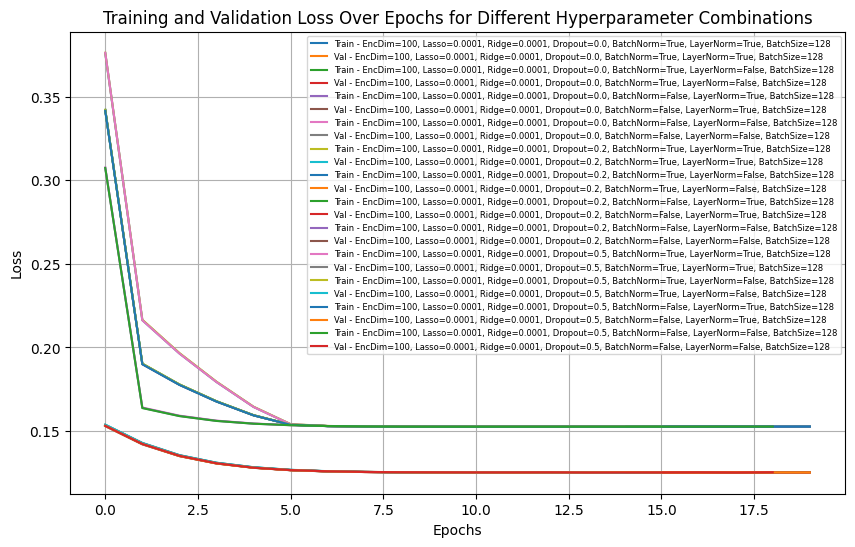

In [ ]:
# Step 3: Combine initial search and regularization search, and plot results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for result in results:
        label = f"EncDim={result['params']['encoding_dim']}, Lasso={result['params']['lasso_lambda']}, Ridge={result['params']['ridge_lambda']}, Dropout={result['params']['dropout_rate']}, BatchNorm={result['params']['use_batch_norm']}, LayerNorm={result['params']['use_layer_norm']}, BatchSize={result['params']['batch_size']}"
        plt.plot(result['train_losses'], label=f"Train - {label}")
        plt.plot(result['val_losses'], label=f"Val - {label}")

    plt.title("Training and Validation Loss Over Epochs for Different Hyperparameter Combinations")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right", fontsize=6)
    plt.grid(True)
    plt.show()

# Run the initial search to get the best parameters
results_initial = initial_hyperparameter_search()

# Select the best configuration based on the validation loss from the initial search
best_result = min(results_initial, key=lambda x: x['val_loss'])
best_params = best_result['params']
print(f"Best hyperparameters found: {best_params}")

# Now perform the regularization search with the best parameters found previously
results_regularization = regularization_search(best_params)

# Plot the results of the regularization search
plot_results(results_regularization)

In [ ]:
best_result_FASHION = min(results_regularization, key=lambda x: x['val_loss'])
best_params = best_result_FASHION['params']
best_val_loss = best_result_FASHION['val_loss']

print(f"Best hyperparameters found for the second grid search: {best_params}")
print(f"Best validation loss: {best_val_loss:.4f}")


Best hyperparameters found for the second grid search: {'encoding_dim': 100, 'lasso_lambda': 0.0001, 'ridge_lambda': 0.0001, 'dropout_rate': 0.2, 'use_batch_norm': True, 'use_layer_norm': True, 'batch_size': 128}
Best validation loss: 0.1251


## PART 3 (methods defined previously)

Training with noise variance: 0.01
Epoch [1/20], Train Loss: 0.0465, Validation Loss: 0.0275
Epoch [2/20], Train Loss: 0.0280, Validation Loss: 0.0243
Epoch [3/20], Train Loss: 0.0255, Validation Loss: 0.0229
Epoch [4/20], Train Loss: 0.0240, Validation Loss: 0.0212
Epoch [5/20], Train Loss: 0.0229, Validation Loss: 0.0205
Epoch [6/20], Train Loss: 0.0221, Validation Loss: 0.0199
Epoch [7/20], Train Loss: 0.0213, Validation Loss: 0.0189
Epoch [8/20], Train Loss: 0.0207, Validation Loss: 0.0185
Epoch [9/20], Train Loss: 0.0203, Validation Loss: 0.0180
Epoch [10/20], Train Loss: 0.0198, Validation Loss: 0.0175
Epoch [11/20], Train Loss: 0.0194, Validation Loss: 0.0174
Epoch [12/20], Train Loss: 0.0191, Validation Loss: 0.0168
Epoch [13/20], Train Loss: 0.0188, Validation Loss: 0.0176
Epoch [14/20], Train Loss: 0.0186, Validation Loss: 0.0167
Epoch [15/20], Train Loss: 0.0182, Validation Loss: 0.0161
Epoch [16/20], Train Loss: 0.0179, Validation Loss: 0.0160
Epoch [17/20], Train Loss: 0.0

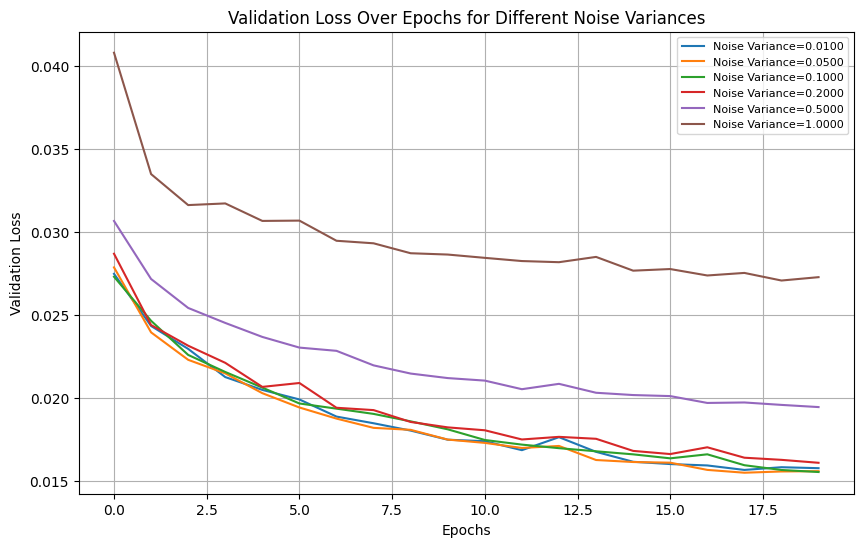

In [ ]:
# Experiment with different noise variances
noise_variances = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
encoding_dim = 100  # Best encoding dimension from previous search
dropout_rate = 0.2  # Based on best results
use_batch_norm = True
use_layer_norm = True
batch_size = 128
num_epochs = 20

# Analyze and plot the results
results = analyze_noise_variance(noise_variances, encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, batch_size, num_epochs)
plot_noise_variance_results(results)

best validation losses for each noise variance:

Noise variance: 0.01 → Best Validation Loss: 0.0156 (Epoch 18)

Noise variance: 0.05 → Best Validation Loss: 0.0155 (Epoch 18 & 19)

Noise variance: 0.1 → Best Validation Loss: 0.0155 (Epoch 20)

Noise variance: 0.2 → Best Validation Loss: 0.0161 (Epoch 20)

Noise variance: 0.5 → Best Validation Loss: 0.0194 (Epoch 20)

Noise variance: 1.0 → Best Validation Loss: 0.0271 (Epoch 19)

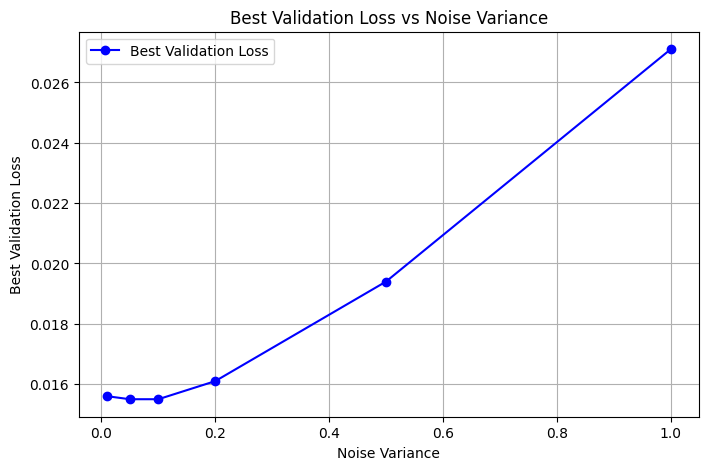

In [ ]:
noise_variances = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]

# Best validation losses for each noise variance
best_validation_losses = [0.0156, 0.0155, 0.0155, 0.0161, 0.0194, 0.0271]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(noise_variances, best_validation_losses, marker='o', linestyle='-', color='b', label="Best Validation Loss")

# Labels and title
plt.xlabel("Noise Variance")
plt.ylabel("Best Validation Loss")
plt.title("Best Validation Loss vs Noise Variance")
plt.grid(True)
plt.legend()

# Show plot
plt.show()


## PART 4

Training with noise variance: 0.05
Epoch [1/20], Train Loss: 0.0466, Validation Loss: 0.0276, PSNR: 13.72
Epoch [2/20], Train Loss: 0.0277, Validation Loss: 0.0244, PSNR: 15.58
Epoch [3/20], Train Loss: 0.0252, Validation Loss: 0.0221, PSNR: 16.00
Epoch [4/20], Train Loss: 0.0240, Validation Loss: 0.0211, PSNR: 16.21
Epoch [5/20], Train Loss: 0.0225, Validation Loss: 0.0201, PSNR: 16.48
Epoch [6/20], Train Loss: 0.0219, Validation Loss: 0.0195, PSNR: 16.61
Epoch [7/20], Train Loss: 0.0211, Validation Loss: 0.0185, PSNR: 16.77
Epoch [8/20], Train Loss: 0.0206, Validation Loss: 0.0182, PSNR: 16.88
Epoch [9/20], Train Loss: 0.0200, Validation Loss: 0.0178, PSNR: 16.99
Epoch [10/20], Train Loss: 0.0197, Validation Loss: 0.0179, PSNR: 17.06
Epoch [11/20], Train Loss: 0.0195, Validation Loss: 0.0171, PSNR: 17.11
Epoch [12/20], Train Loss: 0.0189, Validation Loss: 0.0166, PSNR: 17.24
Epoch [13/20], Train Loss: 0.0187, Validation Loss: 0.0170, PSNR: 17.29
Epoch [14/20], Train Loss: 0.0185, Val

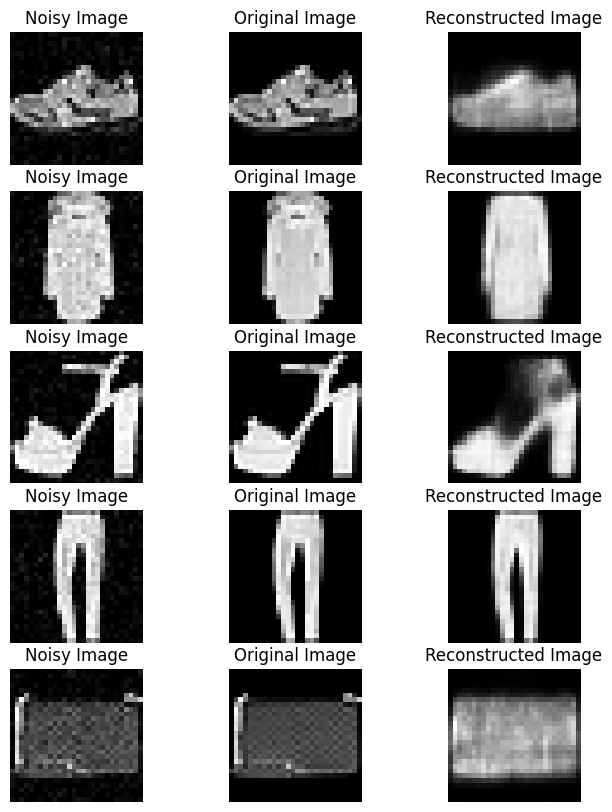

Training with noise variance: 0.1
Epoch [1/20], Train Loss: 0.0469, Validation Loss: 0.0273, PSNR: 13.71
Epoch [2/20], Train Loss: 0.0278, Validation Loss: 0.0240, PSNR: 15.58
Epoch [3/20], Train Loss: 0.0255, Validation Loss: 0.0242, PSNR: 15.94
Epoch [4/20], Train Loss: 0.0240, Validation Loss: 0.0214, PSNR: 16.20
Epoch [5/20], Train Loss: 0.0228, Validation Loss: 0.0203, PSNR: 16.43
Epoch [6/20], Train Loss: 0.0219, Validation Loss: 0.0195, PSNR: 16.60
Epoch [7/20], Train Loss: 0.0213, Validation Loss: 0.0187, PSNR: 16.73
Epoch [8/20], Train Loss: 0.0208, Validation Loss: 0.0187, PSNR: 16.84
Epoch [9/20], Train Loss: 0.0203, Validation Loss: 0.0180, PSNR: 16.94
Epoch [10/20], Train Loss: 0.0199, Validation Loss: 0.0178, PSNR: 17.03
Epoch [11/20], Train Loss: 0.0195, Validation Loss: 0.0176, PSNR: 17.12
Epoch [12/20], Train Loss: 0.0192, Validation Loss: 0.0170, PSNR: 17.17
Epoch [13/20], Train Loss: 0.0189, Validation Loss: 0.0170, PSNR: 17.24
Epoch [14/20], Train Loss: 0.0187, Vali

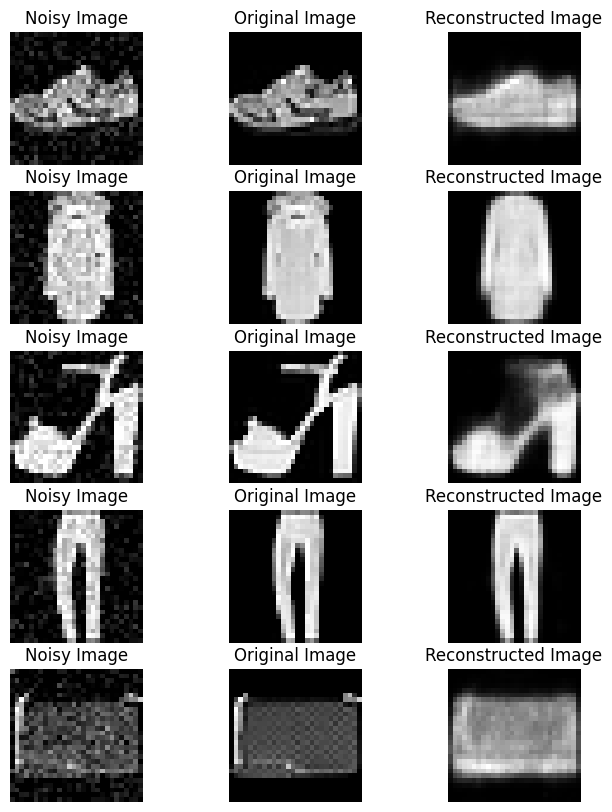

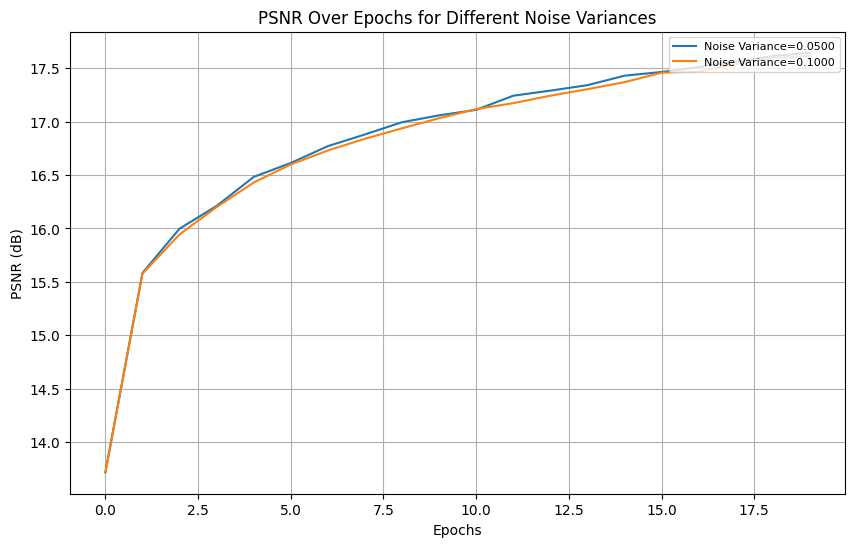

In [ ]:
# Experiment with the 2 best noise variances
noise_variances = [0.05, 0.1]
encoding_dim = 100  # Best encoding dimension from previous search
dropout_rate = 0.2  # Based on best results
use_batch_norm = True
use_layer_norm = True
batch_size = 128
num_epochs = 20

results = analyze_noise_variance_and_visualize(noise_variances, encoding_dim, dropout_rate, use_batch_norm, use_layer_norm, batch_size, num_epochs)

plt.figure(figsize=(10, 6))

for noise_variance, result in results.items():
    plt.plot(result['psnrs'], label=f"Noise Variance={noise_variance:.4f}")

plt.title("PSNR Over Epochs for Different Noise Variances")
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True)
plt.show()

ver siempre limites de hasta donde va bien